# Text Classification of Atis Intents data using CNN model

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
from warnings import filterwarnings
filterwarnings('ignore')
import os

## Data Overview

In [ ]:
df = pd.read_csv('data/AmazonReviews.csv')
df = df[['Score','Text']].copy()
df.rename(columns = {'Score':"Target"}, inplace = True)

df.head(10)

,Target,Text
0,1,These are made in China (do not buy ANY pet fo...
1,3,"Everything is ok, except it just isn't as good..."
2,5,Best cat treat ever. There isn't anything comp...
3,5,My two Corgis were thoroughly spoiled by my la...
4,5,We used to have drive down to the specialty pe...
5,5,"I really liked this coffee, it was just as goo..."
6,2,"I am always looking for healthier, whole grain..."
7,5,"I have tried many different drink mix, this is..."
8,5,This is my favorite item to order for my Keuri...
9,5,"Tastes like Earl Grey, but it's green tea so i..."


In [ ]:
df = df.astype(str)
df.describe()

,Target,Text
count,100000,100000
unique,5,87809
top,5,Diamond Almonds<br />Almonds are a good source...
freq,63988,15


In [ ]:
df.Target.value_counts()

5    63988
4    14221
1     9204
3     7407
2     5180
Name: Target, dtype: int64

In [ ]:
df.Text.duplicated(keep="first").value_counts()

False    87809
True     12191
Name: Text, dtype: int64

In [ ]:
df.drop_duplicates(subset="Text",keep="first",inplace=True,ignore_index=True)
df.describe()

,Target,Text
count,87809,87809
unique,5,87809
top,5,These are made in China (do not buy ANY pet fo...
freq,56115,1


In [ ]:
df.Target.value_counts()

5    56115
4    12495
1     8060
3     6575
2     4564
Name: Target, dtype: int64

### Now we can visualize Category

In [ ]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import plotly.io as pio

init_notebook_mode(True)

fig = px.bar(x=df.Target.value_counts().index,y=df.Target.value_counts(),color=df.Target.value_counts().index,text=df.Target.value_counts())
fig.update_traces(hovertemplate="Score:'%{x}' Counted: %{y}")
fig.update_layout(title={"text":"Review Score","x":0.5,"font":{"size":35}},xaxis={"title":"Review","showgrid":False},yaxis={"title":"Value","showgrid":False},plot_bgcolor="white",width=800,height=500,showlegend=False)
iplot(fig)

In [ ]:
fig1 = px.pie(df,values=df.Target.value_counts(),names=df.Target.value_counts().index)
fig1.update_traces(textposition='auto', textinfo='percent+label',marker={"line":{"width":1}},hoverinfo='label+percent',hole=0.2)
fig1.update_layout(annotations=[{"text":"Percentages","showarrow":False,"font_size":17}])
iplot(fig1)

## Word Overview 

Let's start with word list

In [ ]:
import re

wordList = list()
for i in range(len(df)):
    temp = df.Text[i].split()
    for k in temp:
        k = re.sub("[^a-zA-Z]","",k)
        if k != "":
            wordList.append(k)

In [ ]:
from collections import Counter

wordCount = Counter(wordList)
countedWordDict = dict(wordCount)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)

print("Most Used 20 Words")
for word,counted in sortedWordDict[0:20]:
    print("{} : {}".format(word,counted))

Most Used 20 Words
the : 251238
I : 224148
and : 191185
a : 182836
to : 154424
of : 122209
it : 118996
is : 112404
for : 81056
in : 80364
this : 79463
that : 63861
my : 56272
with : 53440
have : 51766
but : 50507
was : 47924
are : 47156
you : 46317
not : 45852


In [ ]:
num = 75 # For using most used 75 words
list1 = list()
list2 = list()
for i in range(num):
    list1.append(wordCount.most_common(num)[i][0])
    list2.append(wordCount.most_common(num)[i][1])

In [ ]:
fig2 = px.bar(x=list1,y=list2,color=list2,hover_name=list1,hover_data={'Word':list1,"Count":list2})
fig2.update_traces(hovertemplate="Word:'%{x}' Value: %{y}")
fig2.update_layout(title={"text":"Word Values","x":0.5,"font":{"size":30}},xaxis={"title":"Words","showgrid":False},yaxis={"title":"Value","showgrid":False},plot_bgcolor="white")
fig2.show()

### NLP Processing

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import time
import string

ps = PorterStemmer()
stopwordSet = set(stopwords.words('english'))

t = time.time()

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

stop = set(stopwords.words("english"))
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_numbers(text):
    removed_numbers = str.maketrans("", "", r'\d+')
    return text.translate(removed_numbers)

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

textList = df.Text
textList = textList.map(remove_tags)
textList = textList.map(remove_stopwords)
textList = textList.map(remove_punct)
textList = textList.map(remove_numbers)
textList = textList.map(remove_stopwords)
textList = list(textList)

print("Before")
print(df["Text"][2])
print("After")
print(textList[2])
print("Time Passed")
print(time.time()-t)

Before
Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)
After
best cat treat ever anything comparable love cat treats snubs away kin nowi know likes manipulate cattiness treats way manipulating come sit lap chill time
Time Passed
6.8925461769104


In [ ]:
wordList = list()
for i in range(len(textList)):
    temp = textList[i].split()
    for k in temp:
        k = re.sub("[^a-zA-Z]","",k)
        if k != "":
            wordList.append(k)

In [ ]:
wordCount = Counter(wordList)
countedWordDict = dict(wordCount)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)

print("Most Used 20 Words")
for word,counted in sortedWordDict[0:20]:
    print("{} : {}".format(word,counted))

Most Used 20 Words
like : 40956
goo : 30370
taste : 29169
one : 27198
great : 24901
coffee : 23684
prouct : 23049
love : 22356
flavor : 21869
use : 21595
tea : 20108
woul : 18779
foo : 16950
get : 16683
really : 15449
much : 14110
also : 12985
little : 12924
time : 12501
price : 12128


In [ ]:
num = 75 # For using most used 75 words
list1 = list()
list2 = list()
for i in range(num):
    list1.append(wordCount.most_common(num)[i][0])
    list2.append(wordCount.most_common(num)[i][1])
fig2 = px.bar(x=list1,y=list2,color=list2,hover_name=list1,hover_data={'Word':list1,"Count":list2})
fig2.update_traces(hovertemplate="Word:'%{x}' Value: %{y}")
fig2.update_layout(title={"text":"Word Values","x":0.5,"font":{"size":30}},xaxis={"title":"Words","showgrid":False},yaxis={"title":"Value","showgrid":False},plot_bgcolor="white")
fig2.show()

In [ ]:
#preparing y

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
labelEncode = le.fit_transform(df["Target"])
print("LabelEncode")
print(labelEncode)
categorical_y = to_categorical(labelEncode)
print("To_Categorical")
print(categorical_y)

LabelEncode
[0 2 4 ... 2 4 0]
To_Categorical
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


## CNN Building and Fitting 

In [ ]:
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#preparing x for CNN
MAX_FEATURES = 20001

onehot_corpus = []
for text in textList:
    onehot_corpus.append(one_hot(text,MAX_FEATURES))
    
maxTextLen = 0
for text in textList:
    word_token=word_tokenize(text)
    if(maxTextLen < len(word_token)):
        maxTextLen = len(word_token)
        
print("Max number of words : ",maxTextLen)

padded_corpus=pad_sequences(onehot_corpus,maxlen=maxTextLen,padding='post')
x_train2,x_test2,y_train2,y_test2 = train_test_split(padded_corpus,categorical_y,test_size=0.33,random_state=42)

Max number of words :  1939


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.losses import categorical_crossentropy
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(MAX_FEATURES, 100, input_length=maxTextLen))


    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(MaxPooling1D(2))
    #model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=512,activation="relu"))
    
    model.add(Dense(units=y_train2.shape[1],activation="softmax"))
    
    optimizer = Adam(lr=0.000055,beta_1=0.9,beta_2=0.999)
    
    model.compile(optimizer=optimizer,metrics=["accuracy"],loss=categorical_crossentropy)
    return model

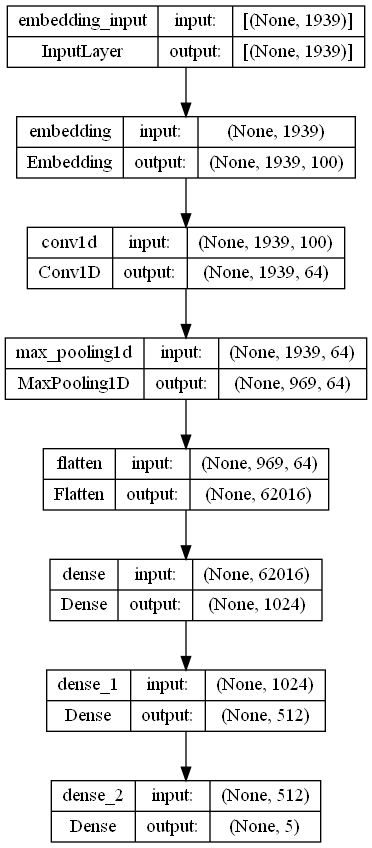

In [ ]:
cnn_model = build_cnn_model()
plot_model(cnn_model,show_shapes=True)

In [ ]:
cnn_history = cnn_model.fit(x_train2,y_train2,epochs=5,batch_size=1280,shuffle=True)
ypred2 = cnn_model.predict(x_test2)

Epoch 1/5
46/46 [==============================] - 1161s 25s/step - loss: 1.1587 - accuracy: 0.6394
Epoch 2/5
46/46 [==============================] - 1421s 31s/step - loss: 1.1239 - accuracy: 0.6394
Epoch 3/5
46/46 [==============================] - 1511s 33s/step - loss: 1.1205 - accuracy: 0.6394
Epoch 4/5
46/46 [==============================] - 1505s 33s/step - loss: 1.1146 - accuracy: 0.6394
Epoch 5/5
906/906 [==============================] - 176s 191ms/step


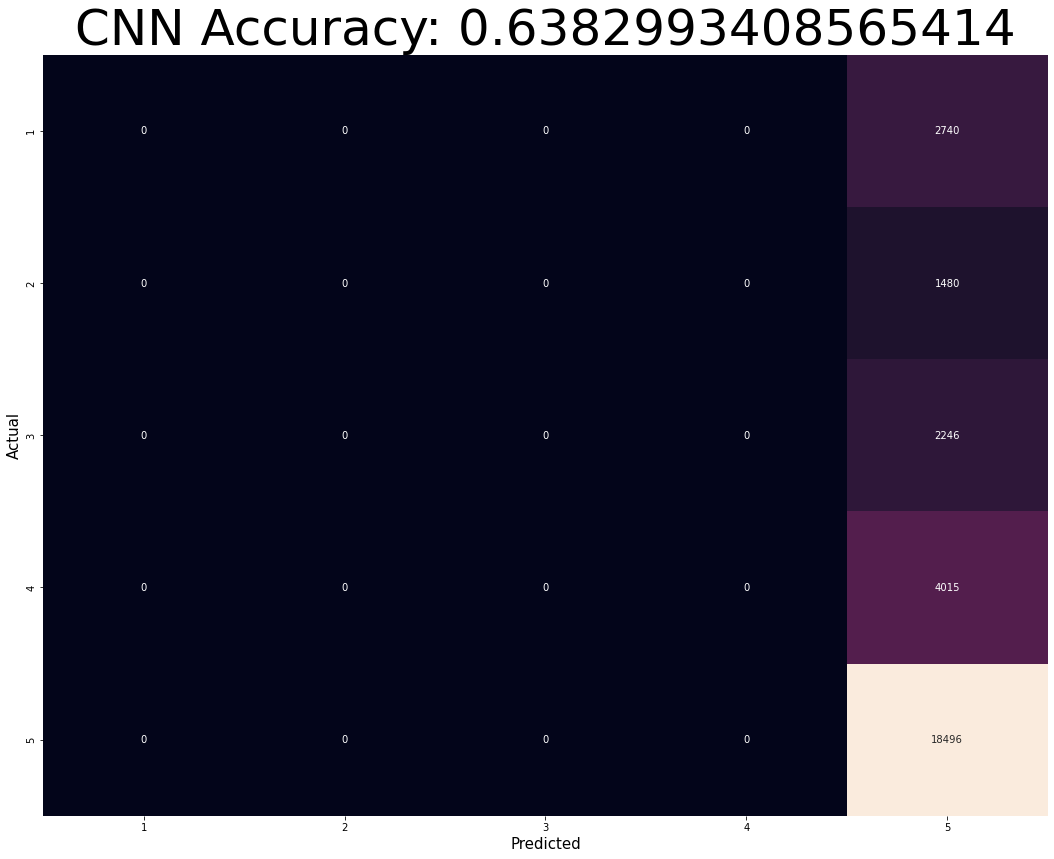

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

cnn_accuracy = accuracy_score(y_test2.argmax(axis=-1),ypred2.argmax(axis=-1))
#print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test2.argmax(axis=-1),ypred2.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cbar=False,xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("CNN Accuracy: {}".format(cnn_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

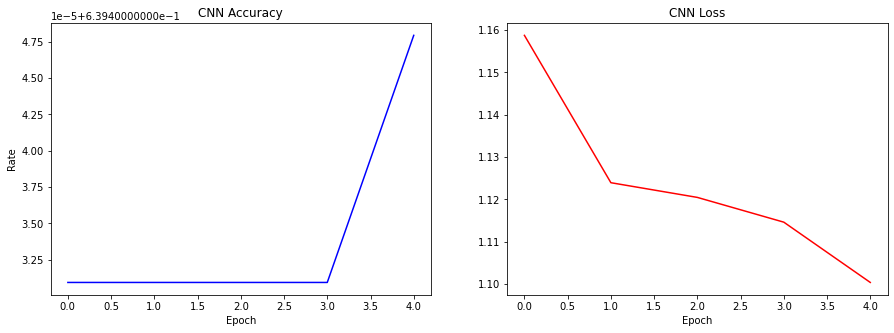

In [ ]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy",color="blue")
axe1[1].plot(cnn_history.history["loss"],label="loss",color="red")
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
def cnn_predict(text):
    text = remove_tags(text)
    text = remove_stopwords(text)
    text = remove_punct(text)
    text = remove_numbers(text)
    puretext = remove_stopwords(text)
    onehottext = one_hot(puretext,MAX_FEATURES)
    text_pad = pad_sequences([onehottext],maxlen=maxTextLen,padding='post')
    predicted = cnn_model.predict(text_pad)
    predicted_category = predicted.argmax(axis=1)
    return le.classes_[predicted_category]
    

In [ ]:
for _ in range(10):
    randint = np.random.randint(len(df))
    text = df.Text[randint]  
    print("  Text")
    print("-"*8)
    print(text)
    print("-"*20)
    print("Actual Category: {}".format(df.Target[randint]))
    print("CNN Predicted Category: {}".format(cnn_predict(text)[0]))
    print("*"*50)

  Text
--------
I am writing this review to warn other dog owners of Blue Buffalo for dogs and what it has done to my 5 yr. old Miniature Dachshund named "Calla". Back in late October 2011 I switched to Blue Buffalo after it was recommended by a family member. By mid-November Calla started to cry out at night. We thought it might be a back issue and our "Three" yes three Vets agreed that it could be Intervertebral Disc Disease. We had blood work done in November and everything looked fine with the exceptions that she was a "little" dehydrated. After months of treatments, with little to no improvement we thought it might be a stomach issue and I started to think about the timing of the change to Blue Buffalo, then I went and goggled "Consumer complaints about Blue Buffalo Pet Foods" and started to really connect the dots. Yesterday she was diagnosed with "Pancreatitis" and needs to be in the hospital for days for treatment. I have spent over 3K to this point and do not know if Calla wil

In [ ]:
#Let me try it too
def predict_print(text):
    print("  Text")
    print("-"*8)
    print(text)
    print("-"*20)
    print("CNN Predicted Category: {}".format(cnn_predict(text)[0]))
    print("*"*50)
myText = "I bought these for Valentine's presents.  We opened one of them right away and it was stale - as were the others.<br /><br />I love the actual product from the grocery store.  "  # 2 
predict_print(myText)
myText = "taste nothing like how cocoa should taste, i'll never touch this again, i'll be trying the swiss miss cocoa maybe better luck"  # 1
predict_print(myText)

  Text
--------
I bought these for Valentine's presents.  We opened one of them right away and it was stale - as were the others.<br /><br />I love the actual product from the grocery store.  
--------------------
1/1 [==============================] - 0s 80ms/step
CNN Predicted Category: 5
**************************************************
  Text
--------
taste nothing like how cocoa should taste, i'll never touch this again, i'll be trying the swiss miss cocoa maybe better luck
--------------------
1/1 [==============================] - 0s 59ms/step
CNN Predicted Category: 5
**************************************************


## We can see that for any text we are only getting 5 as output as it covers around 74% of the dataset. To increase the accuracy we need to make the datasheet balanced.